# Задание

Необходимо написать функцию оценки экспериментов.
Есть данные о пользователях и их покупках за 5 недель. На шестой неделе будет проводиться ряд экспериментов, целью которых было увеличение средней выручки с клиента. Задача функции - определять внедрять изменение или нет.

Информация про эксперименты:
- эксперименты считаем независимыми друг от друга;
- эксперименты проводились на шестой неделе, с 36 по 42 день включительно.
- размеры групп порядка 100-120;
- при дизайне экспериментов предполагалось, что будет применяться двусторонний тест Стьюдента с уровнем значимости 0.05.
- группы для некоторых экспериментов могли выбираться не из всей популяции, а из некоторого подмножества. Например, новые клиенты, которые не совершали покупок ранее.

Всего нужно будет оценить 1000 экспериментов. Оценка будет вычисляться по количеству неверно оценённых экспериментов согласно таблице:

| Количество ошибок | Оценка |
|------|-----|
| <=115 | 10 |
| 116-130 | 9 |
| 131-145 | 8 |
| 146-160 | 7 |
| 161-175 | 6 |
| 176-190 | 5 |
| 191-205 | 4 |
| 206-220 | 3 |
| 221-235 | 2 |
| 236-250 | 1 |
| >250 | 0 |

Дан набор исторических данных `df_sales_history.csv`. Для самопроверки предоставлена подвыборка из 200 экспериментов `experiments_sample.json` и данные о покупках для пользователей этих экспериментов во время эксперимента `df_sales_exp_sample.csv`.

In [ ]:
import os
import json

import numpy as np
import pandas as pd
from scipy import stats


ALPHA = 0.05

# получение данных о покупках
df_sales_history = pd.read_csv('df_sales_history.csv')
df_sales_exp = pd.read_csv('df_sales_exp_sample.csv')


# тут можно предобработать данные df_sales_history и df_sales_exp,
# создать переменные и использовать их внутри функции `check_test`

exp_mean_cost = dict(df_sales_exp.groupby(['user_id', 'day']).sum().groupby('user_id')['cost'].mean())
history_mean_cost = dict(df_sales_history.groupby(['user_id', 'day']).sum().groupby('user_id')['cost'].mean())
history_channel_mean = dict(df_sales_history.groupby(['user_id', 'day']).agg({'cost': 'sum', 
                                                                         'channel': lambda x: np.bincount(x).argmax()}).groupby('channel')['cost'].mean())
user_to_channel = dict(df_sales_exp.groupby('user_id').agg({'channel': lambda x: np.bincount(x).argmax()})['channel'])

def check_test(a, b):
    """Проверяет гипотезу.
    
    :param a: список id пользователей контрольной группы
    :param b: список id пользователей экспериментальной группы
    :return: 1 - внедряем изменение, 0 - иначе.
    """
    a_stats = []
    b_stats = []
    a_history_stats = []
    b_history_stats = []
    for user_id in a:
        history_stat = 0
        if user_id in exp_mean_cost:
            a_stats.append(exp_mean_cost[user_id])
            history_stat = history_channel_mean[user_to_channel[user_id]]
        else:
            a_stats.append(0)
        
        if user_id in history_mean_cost:
            a_history_stats.append(history_mean_cost[user_id])
        else:
            a_history_stats.append(history_stat)

    for user_id in b:
        history_stat = 0
        if user_id in exp_mean_cost:
            b_stats.append(exp_mean_cost[user_id])
            history_stat = history_channel_mean[user_to_channel[user_id]]
        else:
            b_stats.append(0)
        
        if user_id in history_mean_cost:
            b_history_stats.append(history_mean_cost[user_id])
        else:
            b_history_stats.append(history_stat)

    #theta = np.corrcoef(a_stats+b_stats, a_history_stats+b_history_stats)[0, 1]
    theta = np.cov(a_stats+b_stats, a_history_stats+b_history_stats)[0, 1]
    theta /= np.var(a_history_stats+b_history_stats)
    if np.isnan(theta):
        pvalue = stats.ttest_ind(a_stats, b_stats, equal_var=False).pvalue
    else:
        a_stats = np.asarray(a_stats) - theta * np.asarray(a_history_stats)
        b_stats = np.asarray(b_stats) - theta * np.asarray(b_history_stats)
        pvalue = stats.ttest_ind(a_stats, b_stats, equal_var=False).pvalue
    return int(pvalue < ALPHA)


In [48]:
# тесты
with open('experiments_sample.json') as f:
    tests = json.load(f)

errors = []
for has_positive_effect, a, b in tests:
    res = check_test(a, b)
    assert res in [0, 1]
    errors.append(int(res != has_positive_effect))
print(f'Количество ошибок: {np.sum(errors)}\nДоля ошибок: {np.mean(errors)}')

Количество ошибок: 30
Доля ошибок: 0.15


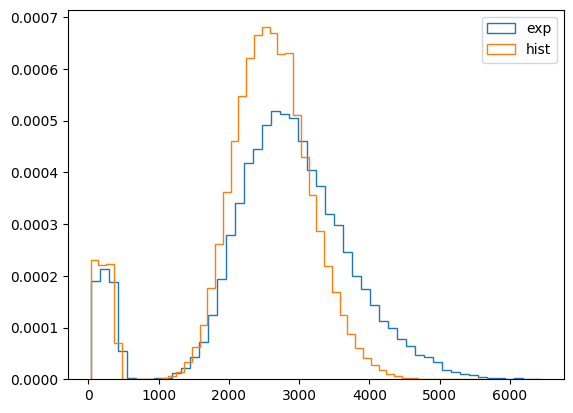

In [19]:
import matplotlib.pyplot as plt
plt.hist(df_sales_exp['cost'], bins=50, label='exp', density=True, histtype='step')
plt.hist(df_sales_history['cost'], bins=50, label='hist', density=True, histtype='step')
plt.legend()
plt.show()

In [26]:
df_sales_exp[df_sales_exp['cost'] < 1000]['user_id'].unique()

array([968468, 915126, 419529, ..., 704019, 347561, 566809])

In [34]:
np.where(df_sales_exp[df_sales_exp['user_id'].isin(df_sales_exp[df_sales_exp['cost'] < 1000]['user_id'].unique())].groupby(['user_id', 'day']).sum()['cost'] < 1000)

(array([ 993, 1283]),)

In [44]:
(df_sales_exp[df_sales_exp['user_id'].isin(df_sales_exp[df_sales_exp['cost'] < 1000]['user_id'].unique())].groupby(['user_id', 'day']).sum()['cost'][df_sales_exp[df_sales_exp['user_id'].isin(df_sales_exp[df_sales_exp['cost'] < 1000]['user_id'].unique())].groupby(['user_id', 'day']).sum()['cost'] == 940])

user_id  day
371402   36     940.0
Name: cost, dtype: float64

In [36]:
df_sales_exp[df_sales_exp['user_id'].isin(df_sales_exp[df_sales_exp['cost'] < 1000]['user_id'].unique())].iloc[993]

user_id    288304.0
day            37.0
cost          280.0
channel         1.0
Name: 4427, dtype: float64

In [45]:
df_sales_exp[df_sales_exp['user_id'] == 371402]

,user_id,day,cost,channel
1951,371402,36,940.0,2
23021,371402,41,2100.0,2
25302,371402,41,60.0,2


In [46]:
df_sales_exp[df_sales_exp['cost'] >= 1000]

,user_id,day,cost,channel
0,643135,36,3150.000000,3
1,885230,36,1760.000000,0
2,255918,36,2830.000000,2
3,575245,36,3150.000000,1
4,470378,36,2200.000000,0
...,...,...,...,...
29980,762412,42,2740.418460,0
29981,800019,42,4255.862429,1
29982,323713,42,3730.000000,1
29983,143090,42,2710.000000,0
